In [14]:
#set working drive
import os
os.chdir("/Users/jacobboysen/myprojects/us-fatal-police-encounters/")

In [15]:
#load packages and data 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
%matplotlib inline
import sys
import pingouin as pg

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#load preppared city data frame from step 1
city_df = pd.read_csv('data/clean_city_data.csv')

#load fatality data and filter to only include those where there was Intentional use of deadly force
fatal_df = pd.read_csv('data/fatal_encounters.csv')
fatal_df = fatal_df[fatal_df['Intentional Use of Force (Developing)'].isin([
    'Intentional use of deadly force','Intentional use of force','Yes', 'Undetermined', 'Unknown'])]



In [16]:
##### INPUTS #####
'''Inputs used as arguements to instantiate the KMeans model and filter data sets.'''

city = "Seattle"               #aka target city: the city would you like to research
number_of_cities = 100         #select the number of top cities you would like to start with 1-200
clusters = 5                   #number of city subsets you would like the model to return
search_variable = '2020_Pop'   #once subsetted, which field would you like to use to further reduce the like city space
search_range = .15             #+/- range of like cities from the target based on the stated search_variable

#potential search variables: 'Rank', 'Name', 'county_name', 'State_x', '2020_Pop', '2010_Census','Change', 
#'Density_km', 'Area_km', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'IncomePerCap', 'Poverty', 
#'Unemployment','pop_change', 'pop_change_per_year', 'est_pop_2011', 'est_pop_2012','est_pop_2013', 'est_pop_2014', 
#'est_pop_2015', 'est_pop_2016','est_pop_2017', 'est_pop_2018', 'est_pop_2019'

In [17]:
#Set data type to date
fatal_df[['Date of injury resulting in death (month/day/year)']] = fatal_df[['Date of injury resulting in death (month/day/year)']].apply(pd.to_datetime)
fatal_df['Date (Month)'] = pd.DatetimeIndex(fatal_df['Date of injury resulting in death (month/day/year)']).month

In [18]:
#define the range of dates we are interested in
full_index = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]

#filter fatality data based on target city
fatal_df_sea = fatal_df[fatal_df['Location of death (city)'] == city] #filter fatality data based on target city
fatal_df_by_year = pd.DataFrame(fatal_df_sea[['Unique ID','Date (Year)']].groupby(by=['Date (Year)']).count()) #group and count number of fatalities by year
fatal_df_by_year = fatal_df_by_year.rename(columns={'Unique ID': 'Count', 'Year': 'Year'}) #rename columns
fatal_df_by_year = fatal_df_by_year.reindex(full_index) #reindex to align with the full_index spine
fatal_df_by_year['Year'] = fatal_df_by_year.index 
fatal_df_by_year = fatal_df_by_year.fillna(0) #fill NaN values with 0

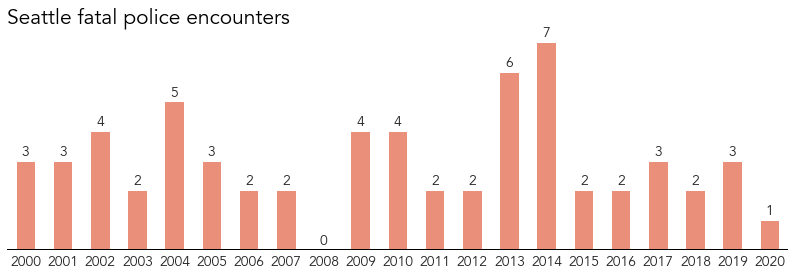

In [19]:
#Bar Plot - Count of Fatal Incidents by Year
#Plot the number of fatal encounters by year and race for the selected city

style.use("seaborn-whitegrid")
csfont = {'fontname':'Avenir'}

# Define plot
myplot1 = fatal_df_by_year.plot.bar(x="Year", y="Count", color="#ea907a", figsize=(14,4))

# Add custom title to plot
''' The plot title is set to be .10 above the tallest bar in the chart. This allows the title to 
automatically adjust height based on the selected city'''
myplot1.text(x=-.5, y=(max(fatal_df_by_year["Count"])*1.10), s = "{} fatal police encounters".format(city), 
        fontsize = 21, weight = 'bold', color="black", **csfont) # Add plot title text. 

plt.axhline(0, color='black', linewidth=2) #Add custom line on the x axis

plt.box(False) #remove plot border

myplot1.grid(False) #remove grid lines

myplot1.axes.yaxis.set_ticklabels([]) #remove y axis labels

myplot1.set_xticklabels(myplot1.get_xticklabels(), rotation=0, **csfont, fontsize =14) #rotate x axis labels

myplot1.get_legend().remove() #remove legend

myplot1.set_xlabel('',size=1) #remove x axis title

#add column annotations to show the count of deaths in the given year
for p in myplot1.patches:
    myplot1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha = 'center', va = 'center', fontsize=14, xytext = (0, 10), textcoords = 'offset points',**csfont)

#export plot to working drive
plt.savefig('png/figure1.png', dpi=100, bbox_inches = "tight")
plt.show()

In [20]:
#Re-pivot data to include race on the x axis and year on the y axis
fatal_df_by_year2 = pd.DataFrame(fatal_df_sea.pivot_table(index='Date (Year)', columns="Subject's race with imputations", values='Unique ID', aggfunc='count'))
fatal_df_by_year2 = fatal_df_by_year2.reindex(full_index) #reindex to account for years with zero records
fatal_df_by_year2 = fatal_df_by_year2.fillna(0) #fill NaN with 0

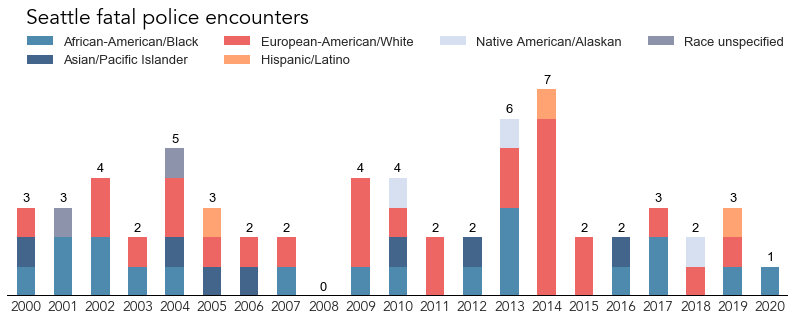

In [21]:
#Bar Plot 2 - Count of Fatal Incidents by Year with Race
#Plot the number of fatal encounters by year and race for the selected city
#style.use("seaborn-whitegrid")
csfont = {'fontname':'Avenir'}

#Define bar chart colors
colors = ['#4e89ae','#43658b','#ed6663','#ffa372','#d6e0f0','#8d93ab']

#Define plot
myplot2 = fatal_df_by_year2.plot.bar(stacked=True, color = colors, figsize=[14,4])

# Add custom title to plot
myplot2.text(x=0, y=(max(fatal_df_by_year["Count"])*1.32), s = "{} fatal police encounters".format(city), 
             fontsize = 21, weight = 'bold', color="black", horizontalalignment= 'left', **csfont)

plt.axhline(0, color='black',  linewidth=2) #set x axis line

plt.box(False) #remove plot border

myplot2.grid(False) #remove grid lines

style = dict(size=13, color='black', horizontalalignment= 'center') 

#add column annotations to show the count of deaths in the given year
for i in range(0,21):
     formula = myplot2.text(i, (int(fatal_df_by_year2.iloc[[i]].sum(axis=1))+.2), int(fatal_df_by_year2.iloc[[i]].sum(axis=1)), style)
     formula

myplot2.set_xlabel('',size=1) #remove x axis title

myplot2.set_xticklabels(myplot2.get_xticklabels(), rotation=0, **csfont, fontsize =14) #rotate x axis labels

myplot2.legend(bbox_to_anchor=(.01, .9999), loc=3, ncol=4, fontsize = 13, frameon=False) #define legend

myplot2.axes.yaxis.set_ticklabels([]) #remove y axis labels

plt.savefig('png/figure2.png', dpi=100,  bbox_inches = "tight")
plt.show()


In [22]:
########### INSTANTIATE UNSUPRERVISED K-MEANS  MODEL ###########

#drop non-numeric and extra columns not used in our model
city_df_log = city_df.drop(columns=['Rank', 'Name', 'county_name','city_state','state', 'pop_change', 'pop_change_per_year', 
                                    'est_pop_2011', 'est_pop_2012', 'est_pop_2013', 'est_pop_2014', 'est_pop_2015', 
                                    'est_pop_2016', 'est_pop_2017', 'est_pop_2018', 'est_pop_2019', 'City',
                                    'State_Code', '2018 total police force', 'total_employees',
                                    '2018 police officers', '2018 police civilians'])
#replace 0 values with NaN
city_df_log = city_df_log.replace(0, np.nan)

#transform numeric values using Log10 then replace NaN with 0
for column in city_df_log.columns:
    try:
        city_df_log[column] = np.log10(city_df_log[column]).fillna(0)
    except (ValueError, AttributeError):
        pass
    
########### RETURN K MEANS MODEL RESULTS AND BIND WITH CITY DATA ###########

#Run KMeans Model and return labels as array
kmeans = KMeans(n_clusters= clusters, max_iter=300, init ="k-means++", random_state=42).fit(city_df_log)
labels = kmeans.labels_

#Transform label array to dataframe and bind with the original data
labels_df = pd.DataFrame(labels[:, None].tolist())
df_labels = pd.concat([city_df, labels_df], axis=1)
df_labels = df_labels.rename(columns={0: 'k_label'})

#Plot cities with assigned cluster based on selected x y dimensions
colors = ['#4e89ae','#43658b','#ed6663','#ffa372','#d6e0f0','#8d93ab']
#style.use("fivethirtyeight")
csfont = {'fontname':'Avenir'}
x = '2020_Pop'
y = 'Black'

#potential search variables: 'Rank', 'Name', 'county_name', 'State_x', '2020_Pop', '2010_Census','Change', 
#'Density_km', 'Area_km', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'IncomePerCap', 'Poverty', 
#'Unemployment','pop_change', 'pop_change_per_year', 'est_pop_2011', 'est_pop_2012','est_pop_2013', 'est_pop_2014', 
#'est_pop_2015', 'est_pop_2016','est_pop_2017', 'est_pop_2018', 'est_pop_2019'

# Build scatterplot
#s = np.random.randint(10, 110)
#plt.plot(figsize=(8,8) )
#plt.title('Scatterplot: {} x {}'.format(x,y), loc="left", fontsize = 14) 
#scatter = plt.scatter(x, y, data = df_labels, c='k_label', s=s ) 
#plt.legend(*scatter.legend_elements(),fontsize = 10, frameon=False)
#plt.show()

df_labels = df_labels.sort_values("Rank", ascending=True)
df_labels = df_labels.head(100)
df_labels = df_labels.drop(columns=['Unnamed: 0'])

In [23]:
#Subset data to return cities that are in the same cluster as the target city and within the defined search range

#return target city cluster
k_search = int(df_labels[df_labels['Name'] == city]['k_label'])

#return base search variable
'''The search_variable is the variable we will use to identify nearest city within the same cluster. The default search 
variable is 2020_Pop, which means this line of code will return the 2020 population for the target city.''' 
pop_search = int(df_labels[df_labels['Name'] == city][search_variable])

#define the lower and upper bonds of the search space.
'''The lower and uppper bonds are set based on the prescribed % from the target city that we are comfortable returning.
If the users sets the search limit to .20 then we will set the bounds to 20% +/- from the search city population'''
upper_limit = pop_search + (pop_search * search_range)
lower_limit = pop_search - (pop_search * search_range)

#filter data set based on the lower and upper bonds and cluster
city_limited_cluster = df_labels[(df_labels['k_label'] == k_search) & (df_labels['2020_Pop'] 
                   <= upper_limit) & (df_labels[search_variable] >= lower_limit)]

#create list of similar cities including the target city based on the cluster and upper and lower bound requirements
city_search_list = city_limited_cluster['Name'].tolist()

#Filter Fatel Encounters data based on the list of target city + similar cities
df_bycity_sub = fatal_df[fatal_df['Location of death (city)'].isin(city_search_list)]
df_bycity_sub["City"] = df_bycity_sub['Location of death (city)'] 

#Pivot results to show the count of incidents by city and year
pivot_df = pd.DataFrame(df_bycity_sub.pivot_table(index='Date (Year)', columns='City', values='Unique ID', aggfunc='count'))
pivot_df = pivot_df.fillna(0) ;
#pivot_df.head(15)

In [24]:
city_search_list

['San Francisco',
 'Indianapolis',
 'Seattle',
 'Denver',
 'Washington',
 'Boston',
 'El Paso',
 'Nashville']

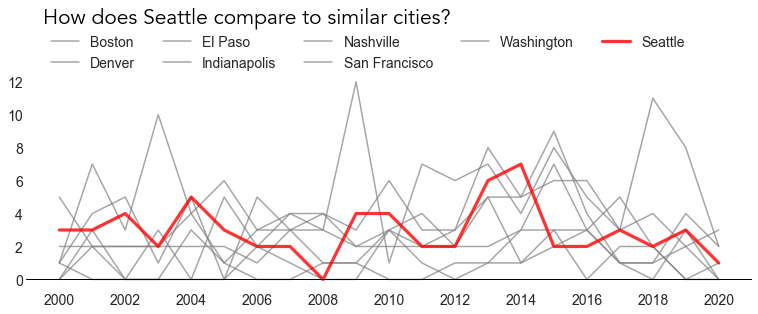

In [25]:
# Line Plot fatalities by city - highlight Seattle red
'''Plotting more than 5 cities all with different colors can be difficult for reader to interpret. The purpose of 
this chart is to give users a general sense of how the selected city peformed relative to other similar cities. 
Plotting more than 5 cities all with different colors can be difficult for  '''

#define plot not including target city
myplot3 = pivot_df.drop(city, axis=1).plot(kind='line', figsize=[13,4], fontsize=14, color='grey', linewidth=1.5, alpha=0.7)

#add line in for target city and highlight red
pivot_df[city].plot(kind='line', figsize=[13,4], color='red', fontsize=14, linewidth=3.2, alpha=0.8)

#add in custom text title
myplot3.text(x = 1999.5, y = (pivot_df.max().max()*1.30), s = "How does {} compare to similar cities?".format(city), 
             fontsize = 21, weight = 'bold', color="black", fontname='Avenir' )

plt.axhline(0, color='black',  linewidth=1) #add custom x axis line

plt.box(False) #remove plot box

myplot3.legend(bbox_to_anchor=(.016, .95), loc=3, ncol=5, fontsize =14, frameon=False) #customize legend

myplot3.grid(False) #remove plot lines

# Remove the label of the x-axis
myplot3.set_xlabel('', fontsize=10) #remove x axis label

xticks = np.arange(2000, 2021, 2) #arrange x axis ticks to occure ever two years

myplot3.set_xticks(xticks)

plt.savefig('png/figure3.png', dpi=100, bbox_inches = "tight") #export image to working drive
plt.show();

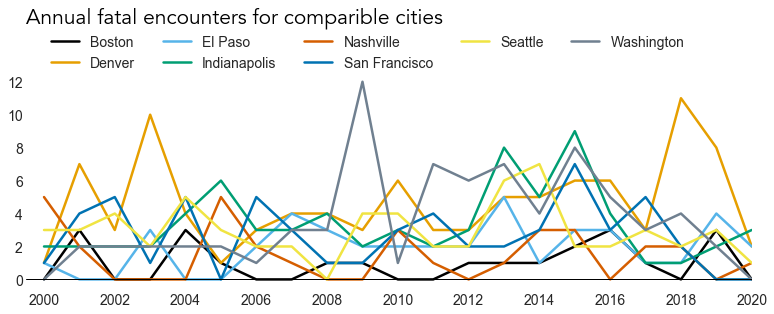

In [26]:
# Line Plot fatalities by city with color

#define font type
csfont = {'fontname':'Avenir'}

#define colors
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255],[240/255,228/255,66/255],[112/255,128/255,144/255],
           [165/255,42/255,42/255]]

#define plot
myplot4 = pivot_df.plot(kind='line', figsize=[13,4], fontsize=14, linewidth = 2.5, color = colors)

plt.axhline(0, color='black',  linewidth=1) #add custom x axis line

myplot4.set_xlim(left = 1999.5, right = 2020) #define x axis range

# add custom text title
myplot4.text(x = 1999.5, y = (pivot_df.max().max()*1.30), s = "Annual fatal encounters for comparible cities", 
             fontsize = 21, weight = 'bold', color="black", fontweight='bold', **csfont)

plt.box(False) #remove plot box

myplot4.legend(bbox_to_anchor=(.016, .95), loc=3, ncol=5, fontsize = 14, frameon=False) #customize legend

myplot4.set_xlabel('',size=1) #remove x axis label

myplot4.grid(False) #remove grid lines

xticks = np.arange(2000, 2021, 2) #arrange x axis ticks to occure ever two years
myplot4.set_xticks(xticks)

plt.savefig('png/figure4.png', dpi=100, bbox_inches = "tight") #export image to working drive
plt.show();

In [27]:
#Pivot fatalitity data to calculate the total, average, median, and standard deviation of fatalities from 2010-2020
metrics_10y = pivot_df.iloc[10:20].agg(['sum','mean','median','std']).round(1)
metrics_10y.rename(index={'sum':'total'},inplace=True)
metrics_10y.rename(index={'std':'sd'},inplace=True)
metrics_10y


,Boston,Denver,El Paso,Indianapolis,Nashville,San Francisco,Seattle,Washington
total,12.0,56.0,24.0,38.0,15.0,31.0,33.0,47.0
mean,1.2,5.6,2.4,3.8,1.5,3.1,3.3,4.7
median,1.0,5.5,2.0,3.0,1.5,3.0,2.5,4.5
sd,1.1,2.5,1.3,2.8,1.3,1.9,1.8,2.3


In [28]:
#Pivot fatalitity data to calculate the total, average, median, and standard deviation of fatalities from 2010-2016
metrics_10y = pivot_df.iloc[1:17].agg(['sum','mean','median','std']).round(1)
metrics_10y.rename(index={'sum':'total'},inplace=True)
metrics_10y.rename(index={'std':'sd'},inplace=True)
metrics_10y

,Boston,Denver,El Paso,Indianapolis,Nashville,San Francisco,Seattle,Washington
total,17.0,73.0,32.0,62.0,21.0,49.0,50.0,67.0
mean,1.1,4.6,2.0,3.9,1.3,3.1,3.1,4.2
median,1.0,4.0,2.0,3.0,1.0,3.0,2.5,3.0
sd,1.1,2.1,1.5,2.2,1.5,1.9,1.8,3.1


''

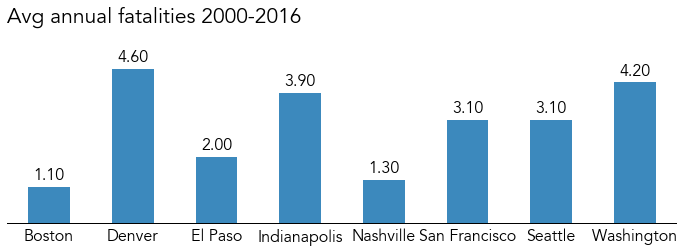

In [29]:
#Generate bar plot of the average number of fatalities from 2010-2019

#define font type
csfont = {'fontname':'Avenir'}
my10y_plot = pd.DataFrame(metrics_10y.loc["mean"]).plot.bar(figsize=(12,3), legend=False, alpha=.87)

plt.text(x = -.5, y = (metrics_10y.loc["mean"].max()*1.30), s = "Avg annual fatalities 2000-2016", 
             fontsize = 21, weight = 'bold', color="black",  **csfont)

plt.axhline(0, color='black',  linewidth=2) #set x axis line

plt.box(False) #remove plot border

my10y_plot.grid(False) #remove grid lines

my10y_plot.set_yticks([]) # remove y axis ticks

my10y_plot.set_xticklabels(my10y_plot.get_xticklabels(), rotation=0, fontsize =16,color="black", **csfont, weight="bold") #rotate x axis labels

for p in my10y_plot.patches: #add column annotations to show the count of deaths in the given year
    my10y_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha = 'center', va = 'center', fontsize = 16, xytext = (0, 12), textcoords = 'offset points',color="black", **csfont)

    plt.savefig('png/figure6.png', dpi=90, bbox_inches = "tight")
;

In [30]:
#Pivot fatalitity data to calculate the total, average, median, and standard deviation of fatalities from 2017-2019

metrics_3y = pivot_df.iloc[17:20].agg(['sum','mean','median','std']).round(1)

metrics_3y.rename(index={'sum':'total'},inplace=True)
metrics_3y.rename(index={'std':'sd'},inplace=True)

metrics_3y
metrics_3y.to_csv('data/3yrmetrics.csv')

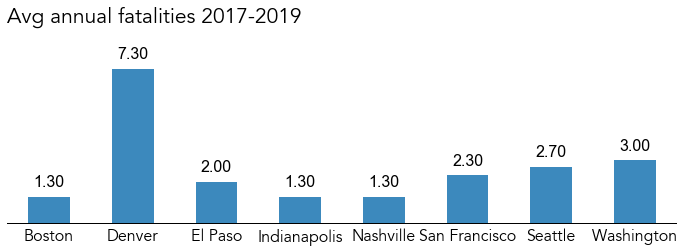

In [31]:
############## AVG FATAL ENCOUNTERS BY CITY (2017-19) ##############
#Generate bar plot of the average number of fatalities from 2017-2019

#define font type
csfont = {'fontname':'Avenir'}

#define plot
my3y_plot = pd.DataFrame(metrics_3y.loc["mean"]).plot.bar(figsize=(12,3), legend=False, alpha=.87)

#add custom text title
plt.text(x = -.5, y = (metrics_3y.loc["mean"].max()*1.30), s = "Avg annual fatalities 2017-2019", 
             fontsize = 21, weight = 'bold', color="black", **csfont)

my3y_plot.set_yticks([]) # remove y axis tick

plt.box(False) #remove plot box

plt.axhline(0, color='black',  linewidth=2) #set x axis line

plt.grid(False) #remove grid lines

my3y_plot.set_xticklabels(my3y_plot.get_xticklabels(), rotation=0, fontsize = 16, weight="bold", color="black",  fontname='Avenir') #rotate x axis labels

for p in my3y_plot.patches: #add column annotations to show the count of deaths in the given year
    my3y_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha = 'center', va = 'center', fontsize=16, xytext = (0, 15), textcoords = 'offset points', color="black", fontname ="Arial")
    
plt.savefig('png/figure7.png', dpi=90, bbox_inches = "tight")

In [32]:
#Filter Fatel Encounters data based on the list of target city + similar cities
scatter_df = fatal_df
scatter_df["City"] = scatter_df['Location of death (city)']
scatter_df["State"] = scatter_df['Location of death (state)']
scatter_df["city_state"] =  scatter_df["City"] + "_" + scatter_df["State"]

#Pivot results to show the count of incidents by city and year
scatter_pivot = pd.DataFrame(scatter_df.pivot_table(index='city_state', columns='Date (Year)', values='Unique ID', aggfunc='count'))
scatter_pivot = scatter_pivot.fillna(0)

#create new column and measure to calculate the average number of fatalities in the given year
scatter_pivot["3Y_Average"] = scatter_pivot.iloc[:,17:20].agg("mean", axis="columns").round(2)
#scatter_pivot.head(15)

In [33]:
#Load 2018 city police data and merge with city fatality stats
city_police_df = pd.read_csv('data/police_departments_2018.csv')

#create unique city_state value to join to other data.
city_police_df["city_state"] =  city_police_df["City"] + "_" + city_police_df["State_Code"]
scatter_data = pd.merge(city_police_df, scatter_pivot, on='city_state', how='left' )

#Create new metrics to determine the ratio of fatalities and police per 10K people
scatter_data["Deaths per 10k"] = scatter_data["3Y_Average"]/(scatter_data["population"]/(10000))
scatter_data["Officers per 10k"] = scatter_data["total_officers"]/(scatter_data["population"]/(10000))
scatter_data = scatter_data.dropna() #drop NA 
scatter_data = scatter_data[scatter_data["Deaths per 10k"] > .0000001] #remove cities with 0 fatalities
scatter_data = scatter_data.sort_values("population", ascending=False) 
scatter_data = scatter_data.head(100) #filter to the top 100 cities based on population in 2018

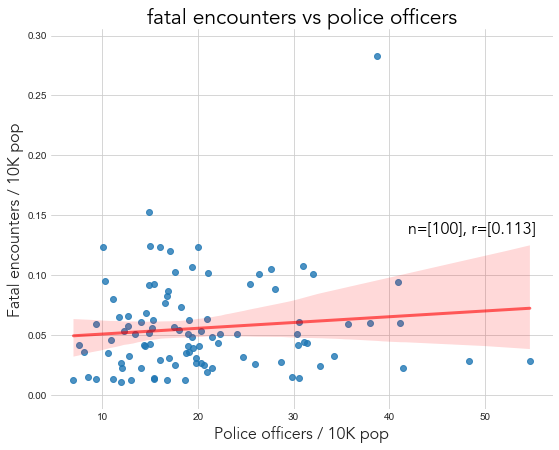

In [34]:
############## FATAL ENCOUNTERS VS POLICE OFFICERS SCATTERPLOT ##############
#Create scatterplot to understand the relationship between Fatal Encounters and the # of Police Officers

#style.use("fivethirtyeight")
csfont = {'fontname':'Avenir'}

x=scatter_data["Officers per 10k"]
y=scatter_data["Deaths per 10k"]

# plot
plt.figure(figsize=(9, 7))
myplot_4 = sns.regplot(x, y, line_kws={"color":"r","alpha":0.6,"lw":3})
plt.title('fatal encounters vs police officers', fontsize=21, color="black", **csfont)
plt.xlabel('Police officers / 10K pop', fontsize=16, **csfont)
plt.ylabel('Fatal encounters / 10K pop', fontsize=16, **csfont)

plt.box(False)

# Calculate the correlation coefficient the output as string
x = pg.corr(x, y)
n = x["n"].tolist()
r = x["r"].round(3).tolist()
string = "n={}, r={}".format(n,r)

# Add correlation coefficient string to scatter plot
myplot_4.text(42, .135, string, fontsize=16, color="black",**csfont)

plt.savefig('png/figure8.png', dpi=120, bbox_inches = "tight") #export image to working drive
plt.show()